# Project03_Deep Learning

## Step 0: Data (MNIST in PyTorch & face data in project_01)

In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F

### MNIST data

Transform that allows images to have the same dimensions and properties.

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

Using MNIST data and  loading them to DataLoader, 
which combines the dataset and a sampler and provides single or multi-process iterators over the dataset.

In [3]:
trainset = datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transform)
valset = datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

Visualize data

In [4]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


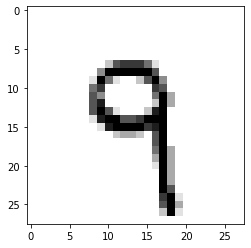

In [5]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');

Visualize more data

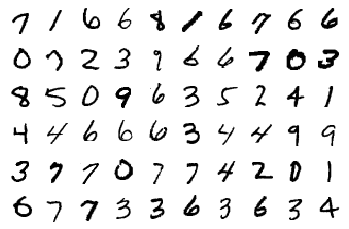

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

Build up neural network, to start with, we simply select 3 fully connected layers, input size is 784 since MNIST with size 28x28

In [7]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax()
)


Define loss

In [8]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

Check initial weights and the weights after back propagation.

In [9]:
print('Before backward pass: \n', model[0].weight.grad)
loss.backward()
print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[-0.0006, -0.0006, -0.0006,  ..., -0.0006, -0.0006, -0.0006],
        [-0.0015, -0.0015, -0.0015,  ..., -0.0015, -0.0015, -0.0015],
        [ 0.0022,  0.0022,  0.0022,  ...,  0.0022,  0.0022,  0.0022],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0023,  0.0023,  0.0023,  ...,  0.0023,  0.0023,  0.0023],
        [ 0.0045,  0.0045,  0.0045,  ...,  0.0045,  0.0045,  0.0045]])


Training the model

In [10]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 15
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 0.6186717495735266
Epoch 1 - Training loss: 0.28177064233846755
Epoch 2 - Training loss: 0.21569430071121848
Epoch 3 - Training loss: 0.17334468151603552
Epoch 4 - Training loss: 0.1455556805442169
Epoch 5 - Training loss: 0.12398229202410496
Epoch 6 - Training loss: 0.1085497444209609
Epoch 7 - Training loss: 0.09703061771867022
Epoch 8 - Training loss: 0.08816801930473907
Epoch 9 - Training loss: 0.07912064898314315
Epoch 10 - Training loss: 0.07134769949267732
Epoch 11 - Training loss: 0.06618028090693859
Epoch 12 - Training loss: 0.061054145580213236
Epoch 13 - Training loss: 0.055116236038597374
Epoch 14 - Training loss: 0.05239115448902919

Training Time (in minutes) = 3.171817417939504


Training process is relatively low. Testing on the validation set

In [11]:
images, labels = next(iter(valloader))
img = images[0].view(1, 784)
with torch.no_grad():
    logps = model(img)
ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))

Predicted Digit = 0


True label is:

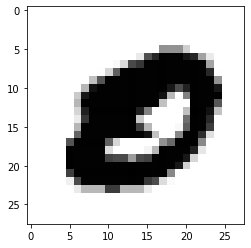

In [12]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');

Iterate through all validation set and calculate the validation accuracy

In [13]:
correct_count, all_count = 0, 0
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    with torch.no_grad():
        logps = model(img)

    
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.9738


Now let's test on our own face dataset.

### Face Dataset from project01

Face dataset is stored in the same path of Notebook, and named "images", there are two folders in the images:
    0.nonface
    1.face
Each picture is sized to 3x28x28, totally we have 1000 face pictures and 1000 nonface pifctures, load these data.

In [14]:
train_data = datasets.ImageFolder('images',transform=transform)

Seperate data set into training set validation set, and testset. 

In [15]:
num_data = len(train_data)
indices_data = list(range(num_data))
np.random.shuffle(indices_data)
split_tt = int(np.floor(0.1 * num_data))
train_idx, test_idx = indices_data[split_tt:], indices_data[:split_tt]

In [16]:
num_train = len(train_idx)
indices_train = list(range(num_train))
np.random.shuffle(indices_train)
split_tv = int(np.floor(0.25 * num_train))
train_idx, valid_idx = indices_train[split_tv:],indices_train[:split_tv]

In [17]:
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [18]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, sampler=train_sampler, num_workers=1)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=32, sampler=valid_sampler, num_workers=1)
test_loader = torch.utils.data.DataLoader(train_data, batch_size=32, sampler = test_sampler, num_workers=1)

Visualize our face dataset

In [19]:
face_dataiter = iter(train_loader)
fake_img, labels = face_dataiter.next()
images = fake_img[:,0,:,:]
print(images.shape)
print(labels.shape)

torch.Size([32, 28, 28])
torch.Size([32])


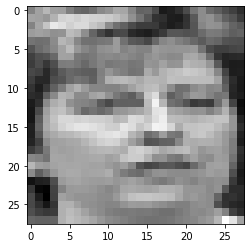

In [20]:
plt.imshow(images[1].numpy().squeeze(), cmap='binary_r');

Visualize more face data.

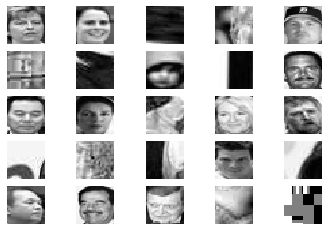

In [21]:
figure = plt.figure()
num_of_images = 25
for index in range(1, num_of_images + 1):
    plt.subplot(5, 5, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(),cmap = 'binary_r')

Due to figure size is 3x28x28, so the input size will be 2352, still keep the other model structure the same
Output size became 2, since it is a binary classification.

In [22]:
input_sizez = 2352
hidden_sizes = [128, 64]
output_size = 2
model = nn.Sequential(nn.Linear(input_sizez, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=2352, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=2, bias=True)
  (5): LogSoftmax()
)


In [23]:
criterion = nn.NLLLoss()
images, labels = next(iter(train_loader))
images = images.view(images.shape[0], -1)
logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [24]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 10
for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        # Flatten face images into a 2352 long vector
        images = images.view(images.shape[0], -1)
        # Training pass
        optimizer.zero_grad() 
        output = model(images)
        loss = criterion(output, labels)
        #This is where the model learns by backpropagating
        loss.backward()
        #And optimizes its weights here
        optimizer.step()
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(train_loader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 0.5943644871545393
Epoch 1 - Training loss: 0.3579843248738799
Epoch 2 - Training loss: 0.26010715926802436
Epoch 3 - Training loss: 0.21717681562484697
Epoch 4 - Training loss: 0.17826545983552933
Epoch 5 - Training loss: 0.15033099878319475
Epoch 6 - Training loss: 0.12760492899390155
Epoch 7 - Training loss: 0.11261311724652039
Epoch 8 - Training loss: 0.09753972300609877
Epoch 9 - Training loss: 0.08662770384229547

Training Time (in minutes) = 0.28656346003214517


Now let's test on testset. 0 is nonface, 1 is face

In [25]:
test_images, test_labels = next(iter(test_loader))
img = test_images[0].view(1, 2352)
with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted =", probab.index(max(probab)))

Predicted = 0


True label is:

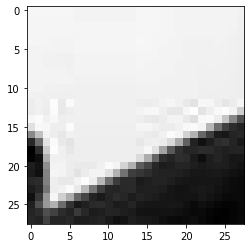

In [26]:
plt.imshow(test_images[0,0,:,:].numpy().squeeze(), cmap='binary_r');

Correct, iterate through all testset and check the accuracy.

In [27]:
correct_count, all_count = 0, 0
for test_images,labels in test_loader:
  for i in range(len(labels)):
    img = test_images[i].view(1, 2352)
    with torch.no_grad():
        logps = model(img)
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1
print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 200

Model Accuracy = 0.97


Accuracy is so high! Actually our facedata is properly croped, so it cotains relatively few noise for model to train.
Next step, we are trying to add more noise to face dataset and check how it influence the results.

## Step 1: preprocess the data and select a data augment scheme.

Pytorch contains different data augmentation method to increase data noise. Here, we simply uses filp, rotation, perspective and bright to increase imgaes complexity, normalize dataset.

In [28]:
rgb_mean = (0.4914, 0.4822, 0.4465)
rgb_std = (0.2023, 0.1994, 0.2010)
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomPerspective(),
    transforms.ColorJitter(),
    transforms.ToTensor(),
    transforms.Normalize(rgb_mean, rgb_std)
    ])

In [29]:
train_data = datasets.ImageFolder('images',transform=transform)
num_data = len(train_data)
indices_data = list(range(num_data))
np.random.shuffle(indices_data)
split_tt = int(np.floor(0.1 * num_data))
train_idx, test_idx = indices_data[split_tt:], indices_data[:split_tt]

In [30]:
num_train = len(train_idx)
indices_train = list(range(num_train))
np.random.shuffle(indices_train)
split_tv = int(np.floor(0.25 * num_train))
train_idx, valid_idx = indices_train[split_tv:],indices_train[:split_tv]

In [31]:
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [32]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, sampler=train_sampler, num_workers=1)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=32, sampler=valid_sampler, num_workers=1)
test_loader = torch.utils.data.DataLoader(train_data, batch_size=32, sampler = test_sampler, num_workers=1)

In [33]:
face_dataiter = iter(train_loader)
fake_img, labels = face_dataiter.next()
images = fake_img[:,0,:,:]
print(images.shape)
print(labels.shape)

torch.Size([32, 28, 28])
torch.Size([32])


Plot images after data augmentation

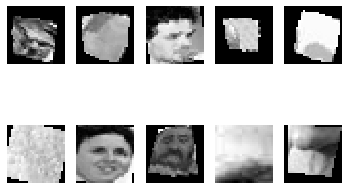

In [34]:
figure = plt.figure()
num_of_images = 10
for index in range(1, num_of_images + 1):
    plt.subplot(2, 5, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(),cmap = 'binary_r')

From above, we still could tell the face and nonface by eyes, but it is much noiser than before.
Input data to three fully connected neural network to see how data augmentation change the results.

In [35]:
input_sizez = 2352
hidden_sizes = [128, 64]
output_size = 2
model = nn.Sequential(nn.Linear(input_sizez, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=2352, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=2, bias=True)
  (5): LogSoftmax()
)


In [36]:
criterion = nn.NLLLoss()
images, labels = next(iter(train_loader))
images = images.view(images.shape[0], -1)
logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

Print out results for every 20 batches.

In [37]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 15
print_every = 20
running_loss = 0
steps = 0
t_accuracy = 0
train_losses, valid_losses = [], []
train_accuracy, valid_accuracy = [], []
for epoch in range(epochs):
    for images, labels in train_loader:
        # Flatten images into a 2352 long vector
        steps += 1
        images = images.view(images.shape[0], -1)
        # Training pass
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        #This is where the model learns by backpropagating
        loss.backward()
        #And optimizes its weights here
        optimizer.step()
        running_loss += loss.item()
        prediction = torch.exp(output)
        t_top_p, t_top_class = prediction.topk(1, dim=1)
        equality = t_top_class == labels.view(*t_top_class.shape)
        t_accuracy += torch.mean(equality.type(torch.FloatTensor)).item()
        if steps % print_every == 0:
            valid_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for valid_images, labels in valid_loader:
                    valid_images = valid_images.view(valid_images.shape[0], -1)
                    valid_output = model(valid_images)
                    batch_loss = criterion(valid_output, labels)
                    valid_loss += batch_loss.item()
                    ps = torch.exp(valid_output)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/print_every)
            valid_losses.append(valid_loss/len(valid_loader))
            train_accuracy.append(t_accuracy/print_every)
            valid_accuracy.append(accuracy/len(valid_loader))
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Train accuracy: {t_accuracy/print_every:.3f}.."
                  f"Validation loss: {valid_loss/len(valid_loader):.3f}.."
                  f"Validation accuracy: {accuracy/len(valid_loader):.3f}")
            running_loss = 0
            t_accuracy = 0
            model.train()
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 1/15.. Train loss: 0.626.. Train accuracy: 0.609..Validation loss: 0.550..Validation accuracy: 0.727
Epoch 1/15.. Train loss: 0.534.. Train accuracy: 0.727..Validation loss: 0.508..Validation accuracy: 0.769
Epoch 2/15.. Train loss: 0.514.. Train accuracy: 0.732..Validation loss: 0.459..Validation accuracy: 0.808
Epoch 2/15.. Train loss: 0.458.. Train accuracy: 0.777..Validation loss: 0.433..Validation accuracy: 0.806
Epoch 3/15.. Train loss: 0.452.. Train accuracy: 0.797..Validation loss: 0.435..Validation accuracy: 0.792
Epoch 3/15.. Train loss: 0.441.. Train accuracy: 0.802..Validation loss: 0.407..Validation accuracy: 0.819
Epoch 4/15.. Train loss: 0.426.. Train accuracy: 0.806..Validation loss: 0.416..Validation accuracy: 0.819
Epoch 4/15.. Train loss: 0.389.. Train accuracy: 0.819..Validation loss: 0.376..Validation accuracy: 0.831
Epoch 5/15.. Train loss: 0.403.. Train accuracy: 0.825..Validation loss: 0.436..Validation accuracy: 0.773
Epoch 5/15.. Train loss: 0.374.. Trai

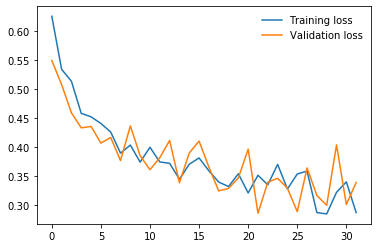

In [38]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

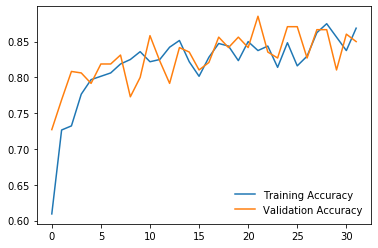

In [39]:
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(valid_accuracy, label='Validation Accuracy')
plt.legend(frameon=False)
plt.show()

In [40]:
correct_count, all_count = 0, 0
for test_images,labels in test_loader:
  for i in range(len(labels)):
    img = test_images[i].view(1, 2352)
    with torch.no_grad():
        logps = model(img)
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1
print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 200

Model Accuracy = 0.805


Compared with the method without data augmentation (previous accuracy for test set is 0.97), with more noise, the accuracy decrease a lot (0.855), which  implies that fully connected neural network will be influenced by data noise. Now that's try more complicated neural network to test if we could still well classify face data if with some noise.

## Step 2: Choose the architecture

Previously, we simply choose three layer fully connected model, with ReLu activation, which proves to be still strong enough to classify the face data, here we apply convolutional layer, pooling, dropout and regularization to test if we could improve accuracy.

In [41]:
face_dataiter = iter(train_loader)
images, labels = face_dataiter.next()
print(images.shape)
print(labels.shape)

torch.Size([32, 3, 28, 28])
torch.Size([32])


Based on previous three fully connected layer, we apply two convolutional layer at the beginning of neural network. first layer is to extract 20 features, second layer is to extract 15 features. Select 3x3 kernel size and apply pool to squeeze the information. Using 0.2 dropout to filter the inforamtion again. The conclusion for network is shown below

In [42]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 20, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(20, 15, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout(0.1)
        self.fc1 = nn.Linear(8 * 8 * 15, 128)
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64, 2)
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out
model = ConvNet()
print(model)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(20, 15, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=960, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)


Instead of NNLoss that is used previously, use CrossEntropyLoss here. Train the convolutional network.

In [43]:
criterion = nn.CrossEntropyLoss()
images, labels = next(iter(train_loader))
logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [44]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 15
print_every = 20
running_loss = 0
steps = 0
t_accuracy = 0
train_losses, valid_losses = [], []
train_accuracy, valid_accuracy = [], []
for epoch in range(epochs):
    for images, labels in train_loader:
        steps += 1
        # Training pass
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        #This is where the model learns by backpropagating
        loss.backward()
        #And optimizes its weights here
        optimizer.step()
        running_loss += loss.item()
        prediction = torch.exp(output)
        t_top_p, t_top_class = prediction.topk(1, dim=1)
        equality = t_top_class == labels.view(*t_top_class.shape)
        t_accuracy += torch.mean(equality.type(torch.FloatTensor)).item()
        if steps % print_every == 0:
            valid_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for valid_images, labels in valid_loader:
                    valid_output = model(valid_images)
                    batch_loss = criterion(valid_output, labels)
                    valid_loss += batch_loss.item()
                    ps = torch.exp(valid_output)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/print_every)
            valid_losses.append(valid_loss/len(valid_loader))
            train_accuracy.append(t_accuracy/print_every)
            valid_accuracy.append(accuracy/len(valid_loader))
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Train accuracy: {t_accuracy/print_every:.3f}.."
                  f"Validation loss: {valid_loss/len(valid_loader):.3f}.."
                  f"Validation accuracy: {accuracy/len(valid_loader):.3f}")
            running_loss = 0
            t_accuracy = 0
            model.train()
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 1/15.. Train loss: 0.683.. Train accuracy: 0.597..Validation loss: 0.677..Validation accuracy: 0.548
Epoch 1/15.. Train loss: 0.669.. Train accuracy: 0.558..Validation loss: 0.649..Validation accuracy: 0.619
Epoch 2/15.. Train loss: 0.642.. Train accuracy: 0.678..Validation loss: 0.608..Validation accuracy: 0.690
Epoch 2/15.. Train loss: 0.582.. Train accuracy: 0.736..Validation loss: 0.535..Validation accuracy: 0.746
Epoch 3/15.. Train loss: 0.570.. Train accuracy: 0.683..Validation loss: 0.524..Validation accuracy: 0.767
Epoch 3/15.. Train loss: 0.518.. Train accuracy: 0.755..Validation loss: 0.433..Validation accuracy: 0.844
Epoch 4/15.. Train loss: 0.427.. Train accuracy: 0.820..Validation loss: 0.349..Validation accuracy: 0.890
Epoch 4/15.. Train loss: 0.321.. Train accuracy: 0.878..Validation loss: 0.284..Validation accuracy: 0.904
Epoch 5/15.. Train loss: 0.298.. Train accuracy: 0.883..Validation loss: 0.269..Validation accuracy: 0.883
Epoch 5/15.. Train loss: 0.264.. Trai

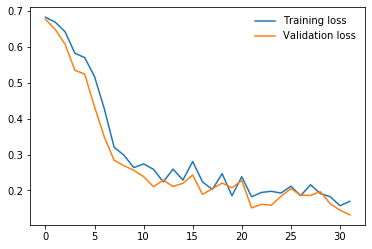

In [45]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

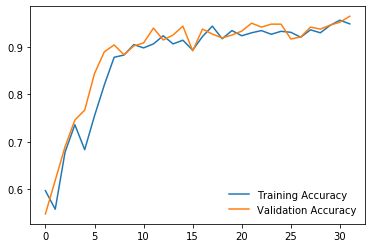

In [46]:
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(valid_accuracy, label='Validation Accuracy')
plt.legend(frameon=False)
plt.show()

The results seem to show better than simple three fully connected layer, let's try on the test set.

In [47]:
# track test loss
classes = [0,1]
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
model.eval()
i=1
# iterate over test data
len(test_loader)
for data, target in test_loader:
    i=i+1
    if len(target)!=32:
        continue
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy())
    # calculate test accuracy for each object class
#     print(target)   
    for i in range(32):       
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))
for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.012936

Test Accuracy of     0: 96% (92/95)
Test Accuracy of     1: 93% (91/97)

Test Accuracy (Overall): 95% (183/192)


So CNN did help to improve accuracy to a certain level, it extract information from noise dataset compared with the fully connected network. Next, we will follow the babysitting procedure to see how parameters will change the network.

Try with small regularization, change learning rate to 1e3.

In [48]:
model1= ConvNet()
optimizer = optim.SGD(model1.parameters(), lr=1e3, momentum=0.9, weight_decay=0.001)
time0 = time()
epochs = 10
print_every = 20
running_loss = 0
steps = 0
t_accuracy = 0
train_losses, valid_losses = [], []
train_accuracy, valid_accuracy = [], []
for epoch in range(epochs):
    for images, labels in train_loader:
        steps += 1
        # Training pass
        optimizer.zero_grad()
        output = model1(images)
        loss = criterion(output, labels)
        #This is where the model learns by backpropagating
        loss.backward()
        #And optimizes its weights here
        optimizer.step()
        running_loss += loss.item()
        prediction = torch.exp(output)
        t_top_p, t_top_class = prediction.topk(1, dim=1)
        equality = t_top_class == labels.view(*t_top_class.shape)
        t_accuracy += torch.mean(equality.type(torch.FloatTensor)).item()
        if steps % print_every == 0:
            valid_loss = 0
            accuracy = 0
            model1.eval()
            with torch.no_grad():
                for valid_images, labels in valid_loader:
                    valid_output = model(valid_images)
                    batch_loss = criterion(valid_output, labels)
                    valid_loss += batch_loss.item()
                    ps = torch.exp(valid_output)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/print_every)
            valid_losses.append(valid_loss/len(valid_loader))
            train_accuracy.append(t_accuracy/print_every)
            valid_accuracy.append(accuracy/len(valid_loader))
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Train accuracy: {t_accuracy/print_every:.3f}.."
                  f"Validation loss: {valid_loss/len(valid_loader):.3f}.."
                  f"Validation accuracy: {accuracy/len(valid_loader):.3f}")
            running_loss = 0
            t_accuracy = 0
            model.train()
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 1/10.. Train loss: nan.. Train accuracy: 0.573..Validation loss: 0.167..Validation accuracy: 0.958
Epoch 1/10.. Train loss: nan.. Train accuracy: 0.547..Validation loss: 0.205..Validation accuracy: 0.919
Epoch 2/10.. Train loss: nan.. Train accuracy: 0.525..Validation loss: 0.141..Validation accuracy: 0.952
Epoch 2/10.. Train loss: nan.. Train accuracy: 0.572..Validation loss: 0.140..Validation accuracy: 0.958
Epoch 3/10.. Train loss: nan.. Train accuracy: 0.551..Validation loss: 0.142..Validation accuracy: 0.954
Epoch 3/10.. Train loss: nan.. Train accuracy: 0.581..Validation loss: 0.153..Validation accuracy: 0.954
Epoch 4/10.. Train loss: nan.. Train accuracy: 0.524..Validation loss: 0.136..Validation accuracy: 0.952
Epoch 4/10.. Train loss: nan.. Train accuracy: 0.556..Validation loss: 0.133..Validation accuracy: 0.958
Epoch 5/10.. Train loss: nan.. Train accuracy: 0.557..Validation loss: 0.145..Validation accuracy: 0.952
Epoch 5/10.. Train loss: nan.. Train accuracy: 0.555..V

No, learning rate is too high

In [49]:
model2= ConvNet()
optimizer = optim.SGD(model2.parameters(), lr=1e-6, momentum=0.9, weight_decay=0.001)
time0 = time()
epochs = 10
print_every = 20
running_loss = 0
steps = 0
t_accuracy = 0
train_losses, valid_losses = [], []
train_accuracy, valid_accuracy = [], []
for epoch in range(epochs):
    for images, labels in train_loader:
        steps += 1
        # Training pass
        optimizer.zero_grad()
        output = model2(images)
        loss = criterion(output, labels)
        #This is where the model learns by backpropagating
        loss.backward()
        #And optimizes its weights here
        optimizer.step()
        running_loss += loss.item()
        prediction = torch.exp(output)
        t_top_p, t_top_class = prediction.topk(1, dim=1)
        equality = t_top_class == labels.view(*t_top_class.shape)
        t_accuracy += torch.mean(equality.type(torch.FloatTensor)).item()
        if steps % print_every == 0:
            valid_loss = 0
            accuracy = 0
            model2.eval()
            with torch.no_grad():
                for valid_images, labels in valid_loader:
                    valid_output = model(valid_images)
                    batch_loss = criterion(valid_output, labels)
                    valid_loss += batch_loss.item()
                    ps = torch.exp(valid_output)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/print_every)
            valid_losses.append(valid_loss/len(valid_loader))
            train_accuracy.append(t_accuracy/print_every)
            valid_accuracy.append(accuracy/len(valid_loader))
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Train accuracy: {t_accuracy/print_every:.3f}.."
                  f"Validation loss: {valid_loss/len(valid_loader):.3f}.."
                  f"Validation accuracy: {accuracy/len(valid_loader):.3f}")
            running_loss = 0
            t_accuracy = 0
            model.train()
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 1/10.. Train loss: 0.697.. Train accuracy: 0.489..Validation loss: 0.151..Validation accuracy: 0.960
Epoch 1/10.. Train loss: 0.694.. Train accuracy: 0.534..Validation loss: 0.145..Validation accuracy: 0.954
Epoch 2/10.. Train loss: 0.696.. Train accuracy: 0.526..Validation loss: 0.150..Validation accuracy: 0.960
Epoch 2/10.. Train loss: 0.695.. Train accuracy: 0.553..Validation loss: 0.141..Validation accuracy: 0.950
Epoch 3/10.. Train loss: 0.700.. Train accuracy: 0.509..Validation loss: 0.136..Validation accuracy: 0.952
Epoch 3/10.. Train loss: 0.697.. Train accuracy: 0.544..Validation loss: 0.150..Validation accuracy: 0.948
Epoch 4/10.. Train loss: 0.696.. Train accuracy: 0.530..Validation loss: 0.194..Validation accuracy: 0.877
Epoch 4/10.. Train loss: 0.703.. Train accuracy: 0.508..Validation loss: 0.158..Validation accuracy: 0.950
Epoch 5/10.. Train loss: 0.694.. Train accuracy: 0.547..Validation loss: 0.151..Validation accuracy: 0.952
Epoch 5/10.. Train loss: 0.693.. Trai

No, learning rate is too low, the accuracy did not improve

In [50]:
model3= ConvNet()
optimizer = optim.SGD(model3.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.001)
time0 = time()
epochs = 15
print_every = 20
running_loss = 0
steps = 0
t_accuracy = 0
train_losses, valid_losses = [], []
train_accuracy, valid_accuracy = [], []
for epoch in range(epochs):
    for images, labels in train_loader:
        steps += 1
        # Training pass
        optimizer.zero_grad()
        output = model3(images)
        loss = criterion(output, labels)
        #This is where the model learns by backpropagating
        loss.backward()
        #And optimizes its weights here
        optimizer.step()
        running_loss += loss.item()
        prediction = torch.exp(output)
        t_top_p, t_top_class = prediction.topk(1, dim=1)
        equality = t_top_class == labels.view(*t_top_class.shape)
        t_accuracy += torch.mean(equality.type(torch.FloatTensor)).item()
        if steps % print_every == 0:
            valid_loss = 0
            accuracy = 0
            model3.eval()
            with torch.no_grad():
                for valid_images, labels in valid_loader:
                    valid_output = model(valid_images)
                    batch_loss = criterion(valid_output, labels)
                    valid_loss += batch_loss.item()
                    ps = torch.exp(valid_output)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/print_every)
            valid_losses.append(valid_loss/len(valid_loader))
            train_accuracy.append(t_accuracy/print_every)
            valid_accuracy.append(accuracy/len(valid_loader))
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Train accuracy: {t_accuracy/print_every:.3f}.."
                  f"Validation loss: {valid_loss/len(valid_loader):.3f}.."
                  f"Validation accuracy: {accuracy/len(valid_loader):.3f}")
            running_loss = 0
            t_accuracy = 0
            model.train()
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 1/15.. Train loss: 0.690.. Train accuracy: 0.509..Validation loss: 0.158..Validation accuracy: 0.958
Epoch 1/15.. Train loss: 0.683.. Train accuracy: 0.550..Validation loss: 0.147..Validation accuracy: 0.950
Epoch 2/15.. Train loss: 0.666.. Train accuracy: 0.594..Validation loss: 0.159..Validation accuracy: 0.954
Epoch 2/15.. Train loss: 0.665.. Train accuracy: 0.550..Validation loss: 0.147..Validation accuracy: 0.956
Epoch 3/15.. Train loss: 0.659.. Train accuracy: 0.585..Validation loss: 0.138..Validation accuracy: 0.950
Epoch 3/15.. Train loss: 0.639.. Train accuracy: 0.625..Validation loss: 0.148..Validation accuracy: 0.960
Epoch 4/15.. Train loss: 0.607.. Train accuracy: 0.715..Validation loss: 0.144..Validation accuracy: 0.958
Epoch 4/15.. Train loss: 0.581.. Train accuracy: 0.753..Validation loss: 0.151..Validation accuracy: 0.946
Epoch 5/15.. Train loss: 0.561.. Train accuracy: 0.748..Validation loss: 0.147..Validation accuracy: 0.950
Epoch 5/15.. Train loss: 0.513.. Trai

So the learning rate should be limited in range [1e-6,1e-3], same method for tuning other parameters. Other babysitting is already shown in the previous steps.